<a href="https://colab.research.google.com/github/jnmcdonald/pizza_text_emb_jm/blob/master/w261_Final_Project_Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# I. Question Formulation

In this final project, we aim to predict whether an individual web surfer will click on a given display ad.

This is important for maximizing the bottom line of an advertising network (Criteo is the ad network that provided our final project dataset, originally released through a Kaggle competition). The company earns revenue when they serve the “right” ads to the “right” people, who sometimes click a compelling offer.

Displaying an inappropriate ad (a coupon for infant diapers to someone not a parent, for instance) is a lost opportunity to show that person a more relevant ad...and thus a missed opportunity to earn revenue.

### Project Justification

What is the point of trying to quickly predict CTR for many ad-surfer combinations?

Criteo states that they must rank eligible ads in real time, once a surfer’s device attempts to load a webpage. If their network can pick and display only the ad (or ads) with the highest likelihood of being clicked by the surfer, then they stand to maximize their advertising earnings. They also take into consideration the price an advertiser is willing/able to pay. So what ultimately determines the ad(s) shown will be a formula represented here:

$$eCPM = (predicted\ probability\ of\ a\ click\ by\ this\ surfer\ on\ this\ ad) \times (advertiser's\ bid\ in\ dollars)$$


Our task in this project is to ensure that the first term - the predicted probability of a click occurring - is right as often as possible, so that better-fit ads don’t get passed over (left on the virtual cutting-room floor) while so-so or poor-fit ads get displayed to the user...who finds them irrelevant and ignores them. Because the outcome of the surfer’s interaction with the display ad is either a click or not a click, we are predicting a binary variable, which is something to which Logistic Regression is particularly well-suited.

How will we know if our model is useful?

Well, one can be *accurate* 74% of the time with this dataset by simply guessing that the user will not click on any add at any time. That’s because the CTR overall is just about 26%. This is not a useful observation, because an algorithm that predicts users never click will serve no display ads, and earn no revenue.  

We found that the Area Under the Receiver Operating Characteristic curve (AUC) performance measure was commonly used in the industry. Because the ROC curve plots basically the true positive rate versus the false positive rate, it focuses evaluation on keeping false positives to a minimum, while maximizing true positive identification. Etsy found that evaluating their algorithms with regard to AUC gave them “a reliable indicator of predictive power...[where] improvements in AUC (> 1%) have consistently resulted in significant CTR wins in multiple rounds of online A/B tests.” We focus therefore on maximizing our AUC, where perfect would be 1.0 or 100%. The best a random choice can do is 0.5 AUC, which means that when you say something will get a click, you’re right half the time and the other half it’s a false positive. So if we have a measure of 0.69, that means that when we say an ad will be clicked, we’re right almost 7 times out of 10…at least on the dev set. And we'll keep trying to beat this.

### About the Dataset

The provided dataset represents a sample of 1 week’s display ad records. The training dataset comes from the first 6 days of that week, and the test set comes from the 7th day’s ads. 13 numerical and 26 categorical fields are provided to “describe” each advertisement that was displayed to a surfer, and a label indicates whether the unknown surfer did in fact click (or not).

Because click-through rates (CTR) are typically quite low (2-3% is actually a very high CTR), we suspect the data provided includes a higher ratio of positive examples than a true random sample, as the average CTR is just over 26% in the provided data. This is likely done to provide a higher ratio of positive examples for model training. It’s similar to how airport Transportation Security Administration (TSA) agents very rarely see a real threat, but most of their training materials (and time investment) focus on how to spot those rare events.

Because the numerical and categorical columns are not decipherable (Criteo did this on purpose to protect the anonymity of advertisers and surfers), we make only general assumptions about the kinds of information these represent. Count data is likely related to how many times an ad has been served and/or clicked-on, perhaps how many times the surfer had visited the site through which the ad was served, etc. Categorical data might include the URL where the ad was displayed, the advertiser’s brand, their industry (sports or music or retail, etc.), as well as tags related to the surfer and the particular ad’s tracking campaign, etc.

Section citations:
* Criteo: https://labs.criteo.com/
* Original Kaggle competition project page: https://www.kaggle.com/c/criteo-display-ad-challenge
* The dataset - fully anonymized - was made available for academic usage after the competition concluded: http://labs.criteo.com/2014/09/kaggle-contest-dataset-now-available-academic-use/
* Etsy paper by Aryafar et al, 2017; An Ensemble-Based Approach to Click-Through Rate Prediction for Promoted Listings at Etsy, https://arxiv.org/pdf/1711.01377.pdf




# II. Algorithm Explanation

## Introduction

There are a number of algorithms that could be used to answer this question. This semester we learned to implement K-Means Clustering, Graph Algorithms, Decision Trees, Support Vector Machines and more. Additional reading discussed Factorization Machines and our group debated applying a Neural Network as well. We could have made a case to implement any of these algorithms. However, we decided on regression - particularly logistic regression - for multiple reasons.

We are working with a large volume of data. As MIDS lecturer Dan Gillick remarked in the asynchronous lectures for Applied Machine Learning, regression can be very effective when you have copious amounts of data. We chose logistic regression over linear regression because our problem is inherently a binary classification problem with two response classes: the consumer clicks or does not click. Logistic regression predicts values mapped between 0 and 1, corresponding to a confidence of a sample being a member of a class. This makes logistic regression easily interpretable for binary classification.

If a company hired us as consultants, we could interpret the coefficients of our model to explain what our model is producing to those who may lack Data Science expertise. The response predicted by the model is the probability that a consumer will click on an ad, given this information. This would enable our customer to say, “we only want to serve ads where the probability of a click is greater than X%.” In this scenario, the ease of interpretability and application outweighs the slight improvements from a more complex algorithm. 


## Theory with Toy Example

In this section, we walk through the steps of logistic regression using a toy example that resembles a subset of the fully pre-processed Criteo dataset.

We have 4 features ('count0', count1', 'count2', 'hashed_category_0') and one label ('clicked'), with 5 total observations. The first three features are all count features which, based on the EDA, are mostly positive values. The feature 'hashed_category_0' resembles a one-hot encoded column from the original feature 'category_0'; therefore, the values will only be 0 or 1. The labels will also be 0 or 1, since they reflect the 'clicked' label of the full datset.

In [0]:
import numpy as np
import matplotlib.pyplot as plt

# build toy dataset resembling the Criteo dataset. last column is one-hot encoded
# assume the data is already scaled
toy_features = np.array(
    [[0.1, 0.2,0.5,0.],
    [2.5, 0.45,0.9,0.], 
    [3.2, 0.6,0.88,1.],
    [1.1, 0.14,0.3,0.], 
    [0.6, 0.8,0.25,1.]])

# build labels for the toy dataset, representing whether that set of features resulted in a click
toy_labels = np.array([0,1,1,0,1])

# Assign the feature names
feature_names = ['bias', 'count0', 'count1', 'count2', 'hashed_category_0']


Using the toy dataset above, we would like to predict the probability that, given 4 features, a certain instance of an ad will result in a click. As mentioned in the introduction, we choose to use logistic regression because it is easily interpretable (in a business context, if this dataset were not anonymized) and is suitable for binary classification problems.

### Explaining Prediction using Logistic Regression

Logistic regression assumes that for a given set of input features $x$, we can determine a set of weights $w$ and a bias term $b$ that, when used to calculate output $y$ below, minimizes the amount of error between the probability of the predicted class and the true class. We predict $y$ using the formula below:

$$y_w(x) = \frac{1}{1+e^{-(wx+b)}}$$

As mentioned earlier, this logistic regression function contains the linear regression term $L = wx+b$ within the exponent; that term gets fed into an “activation function” $\frac{1}{1+e^{-L}}$, meaning it translates the results of the linear regression into a probability bounded by 0 and 1.

Using the toy dataset, let's see what this equation would output for the first record if we simply guessed a vector of weights and bias. We'll assume that each of the 'count' features has a weight of 0.5, the one-hot encoded column has a weight of 2, and there is a bias of 0.2.

In [0]:
# Set weights and bias (pure guess to demonstrate predictions)
# Bias is the first term in the vector
guess_model = np.array([1, 0.5, 0.5, 0.5, 2])

# Get the first record of the dataset and add a [1] in the front to represent the bias term.
# This bias "feature" will be 1 for every observation, so that bias * 1 = bias
first_record = np.insert(toy_features[0],0,1)
first_record

array([1. , 0.1, 0.2, 0.5, 0. ])


To calculate the value of the linear term, we take the dot product of the model and feature vectors. We then plug that number into the "activation function" mentioned above.

In [0]:
# calculate linear term
linear_term = np.dot(first_record, guess_model)

# plug into activation function to get predicted probability
y_pred = 1/(1+np.exp(-linear_term))

# print results
print('The probability that the first observation would result in a click: ', y_pred)
print('Assuming a cutoff of 0.5 for each class, this observation would be classified as ', round(y_pred))
print('The true class is ', toy_labels[0])


The probability that the first observation would result in a click:  0.8021838885585818
Assuming a cutoff of 0.5 for each class, this observation would be classified as  1.0
The true class is  0


Unsurprisingly, our "guessed" model incorrectly predicted the class of this observation. We need machine learning to tell us what the model should actually look like instead of guessing!

### Explaining the Cost Function

So, how do we determine the optimal values of $w$ and $b$? We first need to define “optimal” by choosing the metric that will be used to compare outputs calculated with any given $w$ and $b$ against the true values. If we interpret the output as the probability that the label is 1 (clicked), then we can calculate loss $J$ as the negative log of the predicted value:

$$J(w) = -log(y_w)$$ 

This function can be used to represent loss because, as shown below, the loss decreases in magnitude as the predicted probability of label 1 increases. It is also a smooth function that only increases as the prediction approaches 0, meaning we can easily take the derivative to calculate the gradient.

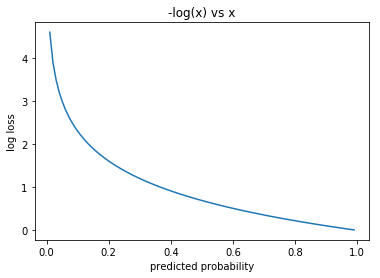

In [0]:
# visualizing the cost function for the positive class
# as predicted probability gets closer to the true label (1), loss approaches 0


x = np.arange(0.01, 1, 0.01)
y = -np.log(x)
plt.plot(x,y)
plt.title('-log(x) vs x')
plt.xlabel('predicted probability')
plt.ylabel('log loss')
plt.show()

Now that we’ve calculated loss for the positive class (label = 1), we need to do the same for the negative class (label = 0). Since this is binary classification, a prediction of 0 would translate to a 0% probability of predicting the positive class, and therefore a 1 - 0 = 100% probability of predicting the negative class (which means there would be no loss). So if we replace the probability of predicting the positive class $y$, with the probability of predicting the negative class, $(1-y)$, we get a cost function of


$$J(w) = -log(1-y_w)$$ 

The next step would be to calculate the gradient by taking the derivative of the cost function, but how do we combine the positive and negative cost functions into one? We only want to capture the loss compared to one label - whichever is the true label. Thanks again to binary classification, we can treat the true label $y_t$ as an activation term so that only the positive or negative cost is used:

$$J(w) = -y_tlog(y_w)-(1-y_t)log(1-y_w)$$ 

Now, if the true class $y_t$ is equal to 1, the second term will be canceled so we will only calculate the loss from the positive class, and vice versa. 

To scale this equation over multiple records and get the total loss for the dataset, we sum the loss and divide by total number of observations:

$$J(w) = -\frac{1}{m}\sum_{i=1}^m y_{t,i}log(y_{w,i})+(1-y_{t,i})log(1-y_{w,i}),$$

where $y_{w,i}$ represents the function $y_w(x_i)$. 

Let's see how the cost function would look for our toy dataset, given the "guessed" model. We first need to generate all the predictions as we did with the first observations, and then take the negative log of both the values and (1-values) to get total log-loss.

In [0]:
# add the bias term in as the first "feature" for all of the observations
bias = np.ones((5,1))
toy_features_bias = np.hstack((bias, toy_features))

# calculate all of the predictions
y_pred = 1/(1+np.exp(-np.dot(toy_features_bias, guess_model)))

# calculate the log-loss for each observation
logloss = -toy_labels*np.log(y_pred) - (1-toy_labels)*np.log(1-y_pred)

# display the results
for i in range(len(toy_labels)):
  print('Predicted probability: ', y_pred[i], 'Predicted class: ', round(y_pred[i]),
        'True class: ', toy_labels[i], 'Log loss: ', logloss[i])

# calculate the mean log-loss for the entire dataset
print("Average log-loss for this model: ", logloss.mean())

Predicted probability:  0.8021838885585818 Predicted class:  1.0 True class:  0 Log loss:  1.6204174099184512
Predicted probability:  0.9490685297470565 Predicted class:  1.0 True class:  1 Log loss:  0.052274270390312086
Predicted probability:  0.9952270198852368 Predicted class:  1.0 True class:  1 Log loss:  0.0047844071595555815
Predicted probability:  0.8544576710630347 Predicted class:  1.0 True class:  0 Log loss:  1.9272883141507904
Predicted probability:  0.9786474438389795 Predicted class:  1.0 True class:  1 Log loss:  0.02158381996264806
Average log-loss for this model:  0.7252696443163514


It looks like our guessed model predicted that all of these ad instances would have resulted in a click, when actually only 3/5 did. It's not surprise that the two observations that were incorrectly predicted show the highest log loss. We also observe that the average log-loss for this guessed model is 0.73. The objective of logistic regression is to minimize that number, so we have a long way to go!

### Explaining Regularization

In order to prevent overfitting the training data, we can also introduce a regularization term that penalizes the cost function if the weights are too high. In Ridge regression, the penalty is determined by the squares of the weights, as well as a parameter $\lambda$ that adjusts the overall severity and can be tuned manually. The total cost function with Ridge regression is 


$$J(w) = -\frac{1}{m}\big[\sum_{i=1}^m y_{t,i}log(y_{w,i})+(1-y_{t,i})log(1-y_{w,i})\big] + \frac{\lambda}{m}\sum_{j=1}^{l}w_j^2$$


where $l$ is the total number of features. The Lasso method of regularization is similar, but instead of trying to minimize all of the weights, it tries to remove as many features as possible to reduce overfitting. This can be done by taking the sum of the absolute value of the weights as a penalty, instead of the squares. The cost function for Lasso is 


$$J(w) = -\frac{1}{m}\big[\sum_{i=1}^m y_{t,i}log(y_{w,i})+(1-y_{t,i})log(1-y_{w,i})\big] + \frac{\lambda}{m}\sum_{j=1}^{l}|w_j|$$


Let's see what regularization does to the log loss on the toy dataset. We'll stick with Ridge regression in this example, since we don't have that many features to remove through Lasso:

In [0]:
# calculate the regularization term for the toy dataset
# assume lambda = 0.1
regParam = 0.1
reg_term = regParam/(2*len(toy_labels))*np.sum(guess_model**2)

# compare the total loss with and without regularization 
print('Loss: ', logloss.mean(), 'Loss w/ reg: ', logloss.mean() + reg_term)

Loss:  0.7252696443163514 Loss w/ reg:  0.7827696443163514


Of course, the loss is higher with regularization because it's adding a penalty based on our weights. If we had lower weights across the board, the penalty would decrease; if we had one feature that stood out extremely high, the penalty would also increase by the square of that feature.

### Explaining the Gradient Function

We can now minimize the cost function by calculating the gradient $\frac{\delta}{\delta w}J(w)$, which is used to update the weight vector $w$ with each iteration of gradient descent:

$$\frac{\delta}{\delta w}J(w) = \frac{1}{m}\sum_{i=1}^m x_i(y_{w,i} - y_{t,i})$$

Adding in the derivative of the Ridge regularization term, we get

$$\frac{\delta}{\delta w}J(w) = \frac{1}{m}\sum_{i=1}^m x_i(y_{w,i} - y_{t,i}) + 2\frac{\lambda}{m}w$$

This gradient value is what's used at each iteration of gradient descent, where the weight vector that we had initially "guessed" moves closer and closer to the optimal weight vector that produces the least log-loss.

### Explaining the Gradient Descent Update

The size of the step change in the weight vector is dependent not only on the gradient, but also the learning rate, which is a hyperparameter that must be declared or optimally searched during development of a model. Bringing those two terms together, we get the formula for the new weight vector:

$$w_{new} = w_{old} - \alpha\frac{\delta}{\delta w}J(w)$$

Let's calculate the gradient for the toy dataset and see what our new weight vector will be. We can then compare the predictions and loss of the initial "guessed" weight vector to those of the updated one to confirm that the weights are moving closer to the right direction.

In [0]:
# calculate the gradient term for the toy dataset
grad = (1/len(toy_labels) * (y_pred - toy_labels).dot(toy_features_bias)) + regParam * 2 * guess_model

# set the learning rate equal to 0.1
alpha = 0.1

# calculate the new weights
new_model = guess_model - alpha*grad

# print the current weights, the step size change, and the new weights
for i in range(len(guess_model)):
  print(feature_names[i],' - ', 'old weight: ', guess_model[i], 'new weight: ', new_model[i])

bias  -  old weight:  1.0 new weight:  0.9484083089381422
count0  -  old weight:  0.5 new weight:  0.47270583837342034
count1  -  old weight:  0.5 new weight:  0.48525608285901917
count2  -  old weight:  0.5 new weight:  0.4779589487834139
hashed_category_0  -  old weight:  2.0 new weight:  1.9605225107255158


In [0]:
# Now let's compare the predictions using both the old and new model

# first make the predictions using the new model
y_pred_new = 1/(1+np.exp(-np.dot(toy_features_bias, new_model)))

# print the comparison between predictions and true class
for i in range(len(toy_labels)):
  print('Old prediction: ', y_pred[i], 'New prediction: ', y_pred_new[i],
        'True class: ', toy_labels[i])


Old prediction:  0.8021838885585818 New prediction:  0.7911232793781322 True class:  0
Old prediction:  0.9490685297470565 New prediction:  0.9415139662749734 True class:  1
Old prediction:  0.9952270198852368 New prediction:  0.9941377776095319 True class:  1
Old prediction:  0.8544576710630347 New prediction:  0.8428658970431786 True class:  0
Old prediction:  0.9786474438389795 New prediction:  0.9758788388319649 True class:  1


In [0]:
# and the logloss comparison

# calculate the new log-loss for each observation
logloss_new = -toy_labels*np.log(y_pred_new) - (1-toy_labels)*np.log(1-y_pred_new)
reg_term_new = regParam/(2*len(toy_labels))*np.sum(new_model**2)

# compare old and new model loss
print('Old model: ', logloss.mean()+reg_term, 'New model: ', logloss_new.mean()+reg_term_new)

Old model:  0.7827696443163514 New model:  0.7557507875186116


With this model update, our average log-loss has decreased as we had hoped. If we continued to run this model update for multiple iterations, eventually we would near the minimum possible amount of loss. At that point the weight vector would represent the best model to fit the dataset.



Section citations:
* ML Cheatsheet: https://ml-cheatsheet.readthedocs.io/en/latest/logistic_regression.html
* Machine Learning Medium: https://machinelearningmedium.com/2017/09/15/regularized-logistic-regression/

# III. EDA & Discussion of Challenges

### Notebook Setup

We'll now get our notebook set up to run Spark.

#### Package Installations

First we install some needed packages.

In [0]:
!pip install --upgrade pip
!pip install -q findspark
!pip install pyspark_dist_explore
!pip install pyspark

Requirement already up-to-date: pip in /usr/local/lib/python3.6/dist-packages (19.0.3)
    100% |████████████████████████████████| 215.7MB 69kB/s 
    100% |████████████████████████████████| 204kB 29.2MB/s 
  Stored in directory: /root/.cache/pip/wheels/47/9b/57/7984bf19763749a13eece44c3174adb6ae4bc95b920375ff50
Successfully built pyspark



#### Mount Google Drive to this Colab

And we'll mount to our Google drive, where we are have our small samples of the dataset stored.

In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


#### Install Spark 

When running on Colab outside of a Dataproc cluster, we need to install and configure Spark.

In [0]:
cd /content/gdrive/'My Drive'/w261-final-project/notebook-data

/content/gdrive/My Drive/w261-final-project/notebook-data


In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
# If needed uncomment the below to download the tar file
#!wget -q http://apache.osuosl.org/spark/spark-2.4.0/spark-2.4.0-bin-hadoop2.7.tgz
!tar xf spark-2.4.0-bin-hadoop2.7.tgz 

In [0]:
import os
import time
import findspark
import numpy as np
import pyspark.sql
import pyspark_dist_explore 
import matplotlib.pyplot as plt
from collections import defaultdict

from itertools import combinations
from pyspark.sql.types import *
from pyspark.sql import functions as F
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml import Pipeline
from pyspark.ml.feature import Imputer, StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.feature import OneHotEncoderEstimator, PolynomialExpansion
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.linalg import Vectors
from pyspark.sql import types as t
from pyspark.ml.linalg import SparseVector, DenseVector
from pyspark.sql.functions import when
from pyspark.sql import SQLContext
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import FeatureHasher
from pyspark.sql.functions import monotonically_increasing_id

from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit

#### Set Environment Variables

In [0]:
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64/"
os.environ["SPARK_HOME"] = "/content/gdrive/My Drive/w261-final-project/notebook-data/spark-2.4.0-bin-hadoop2.7/"

#### Initialize Spark

In [0]:
findspark.init()
spark = SparkSession.builder.master("local[*]").getOrCreate()
sc = spark.sparkContext

### Loading Data and Sampling

We looked at the original dataset and saw it was  45 million rows, which we knew would be difficult to work with.

We chose to sample at 0.01% for a toy set to build our pipeline and 1% for a sample set to make hyperparameter decisions. The 1% decision came from section 5.3 of this [paper](https://www.dropbox.com/s/s4x7wp8gjsh021d/TISTRespPredAds-Chappelle-CTR-Prediction-2014Paper.pdf?dl+=0),  with the sentence starting, "We found empirically..."

We wanted to sample randomly across the dataset rather than taking the first x rows, so we used the following Unix commands to stream over the data and subset:

```
cat train.txt | awk 'BEGIN {srand()} !/^$/ { if (rand() <= .0001) print $0}' > train_tiny.txt

cat train.txt | awk 'BEGIN {srand()} !/^$/ { if (rand() <= .01) print $0}' > train_small.txt
```

### Make Useful Headers

The dataset contained one column indicating whether an advertisement was clicked, thirteen columns of count data and twenty-six columns of categorical data.  So we  created these headers for the input of our data.

In [0]:
headers = ['clicked'] + [f"count{i}" for i,_ in enumerate(range(13))] + [f"category{i}" for i,_ in enumerate(range(26))]

### Load Files into Dataframes

Next, the sampled data was loaded into a dataframe.

The `sep="\t"` option was used in the import  to create columns from tab delineations. And the header list created above is passed in as the dataframe header.

In [0]:
tinyDF_raw = spark.read.load('/content/gdrive/My Drive/w261-final-project/notebook-data/train_tiny.txt', format='csv', sep="\t").toDF(*headers)
# smallDF_raw = spark.read.load('/content/gdrive/My Drive/w261-final-project/notebook-data/train_small.txt', format='csv', sep="\t").toDF(*headers)
# fullDF_raw = spark.read.load('gs://w261_jm/train.txt', format='csv', sep="\t").toDF(*headers)

In order to maintain flexibility with our code, we assign the dataset we are currently working with the pseudonym of the full dataset.

In [0]:
fullDF_raw = tinyDF_raw

### Break Data into Train, Dev, Test Sets

It was of course important to split the data so that we could explore models with a training set, evaluate on a dev set, and hold aside the test set in pristine condition so that we could later find out for real just how our final model (in this case 2 final models) would perform on formerly unseen data.

We did this before our EDA because we did not want our held out test data to influence any design decisions we planned to make.

In [0]:
start = time.time()
# number of rows should equal 45,840,617
num_rows = fullDF_raw.count()

# 75/15/10 train/dev/test split
TRAIN_PORTION = 0.75
DEV_PORTION = 0.15
TEST_PORTION = 0.10

# number of rows in each set
TRAIN_COUNT = int(TRAIN_PORTION*num_rows) # 34,380,463
DEV_COUNT = int(DEV_PORTION*num_rows) # 6,876,093
TEST_COUNT = int(TEST_PORTION*num_rows) # 4,584,061

# create split indices
TRAIN_INDEX = TRAIN_COUNT
DEV_INDEX = TRAIN_COUNT + DEV_COUNT
 
# create indices to split on
fullDF_raw_idx = fullDF_raw.withColumn("idx", monotonically_increasing_id())
fullDF_raw_idx.select('idx').createOrReplaceTempView('df')
idx_rdd = spark.sql('select row_number() over (order by "idx") as num, * from df')
fullDF_raw_idx = fullDF_raw_idx.join(idx_rdd, idx_rdd['idx'] == fullDF_raw_idx['idx'], how='left')

# create train, dev, test dataframes based on index
train_df_raw = fullDF_raw_idx.filter(f"num < {TRAIN_INDEX}")
dev_df_raw = fullDF_raw_idx.filter(f"num < {DEV_INDEX} and num >= {TRAIN_INDEX}")
test_df_raw = fullDF_raw_idx.filter(f"num >= {DEV_INDEX}")

# drop the idx column
train_df_raw.drop(*['idx','num'])
dev_df_raw.drop(*['idx','num'])
test_df_raw.drop(*['idx','num'])

DataFrame[clicked: string, count0: string, count1: string, count2: string, count3: string, count4: string, count5: string, count6: string, count7: string, count8: string, count9: string, count10: string, count11: string, count12: string, category0: string, category1: string, category2: string, category3: string, category4: string, category5: string, category6: string, category7: string, category8: string, category9: string, category10: string, category11: string, category12: string, category13: string, category14: string, category15: string, category16: string, category17: string, category18: string, category19: string, category20: string, category21: string, category22: string, category23: string, category24: string, category25: string]

### Verify and Preview Data

We examine one row of training data to ensure that our split did not drop any original columns and to also preview what kind of data we'll be working with.

In [0]:
train_df_raw.show(n=1, truncate=False)
print(f"Ran in {(time.time() - start) // 60} minutes & {round((time.time() - start) % 60, 0)} seconds.")

+-------+------+------+------+------+------+------+------+------+------+------+-------+-------+-------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+---+---+---+
|clicked|count0|count1|count2|count3|count4|count5|count6|count7|count8|count9|count10|count11|count12|category0|category1|category2|category3|category4|category5|category6|category7|category8|category9|category10|category11|category12|category13|category14|category15|category16|category17|category18|category19|category20|category21|category22|category23|category24|category25|idx|num|idx|
+-------+------+------+------+------+------+------+------+------+------+------+-------+-------+-------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+----------+--

It appeared that we would be dealing with integer values for our numeric columns and anonymized data for our categorical columns. It was important to observe that not all columns had data. Both the numeric and categorical columns had null values.

### Examining Overall CTR of our Training Sample

Next, we made some high-level explorations of our data. How many ads were clicked and how many were not clicked?

In [0]:
# Examine overall CTR of our training sample
overall = tinyDF_raw.select("clicked") \
      .rdd \
      .map(lambda x: (x,1)) \
      .reduceByKey(lambda a,b: a+b) \
      .toDF(['clicks', 'howOften']) \
      .cache()

overall.show(3)

+------+--------+
|clicks|howOften|
+------+--------+
|   [0]|    3343|
|   [1]|    1182|
+------+--------+



The overall CTR was 1182/4525 = 26.12%. This number is quite high and tells us that the data is likely downsampled. 

### Exploring Missing Data in the Dataset

Next, we wanted to interrogate the null values we had seen in our preview. Is this positively or negatively associated with CTR?

In [0]:
def report_columns_missing_a_value(row):
  """
  Emit a record reporting whether a column's missing value
  was associated with a click or a nonclick.
  Returns column index as key and tuple of (nonclicks,clicks)
  """
  clicked = int(row[0])
  rest = row[1:]
  for idx, val in enumerate(rest):
    if val==None:
      if clicked:
        yield "col"+str(idx),(0,1)
      else:
        yield "col"+str(idx),(1,0)

In [0]:
nobs=4525
oCTR = 26.12
missingsEDA = tinyDF_raw \
      .rdd \
      .flatMap(report_columns_missing_a_value) \
      .reduceByKey(lambda x,y: (x[0]+ y[0], x[1]+y[1])) \
      .mapValues(lambda x: ((round(float((x[0]+x[1])/nobs)*100,2)),(round(float(x[1]/(x[0]+x[1])*100),2)),(round(float(x[1]/(x[0]+x[1])*100-oCTR),2)))) \
      .map(lambda x: (int(x[0][3:]),x[1][0],x[1][1],x[1][2]))\
      .toDF(['column', 'percent_missing','CTR_when_missing','CTR_delta_when_missing'])\
      .sort(['column']) \
      .cache()


missingsEDA.show(n=40, truncate=False)

+------+---------------+----------------+----------------------+
|column|percent_missing|CTR_when_missing|CTR_delta_when_missing|
+------+---------------+----------------+----------------------+
|0     |46.19          |19.9            |-6.22                 |
|2     |21.88          |31.41           |5.29                  |
|3     |22.28          |27.28           |1.16                  |
|4     |2.9            |11.45           |-14.67                |
|5     |22.63          |12.89           |-13.23                |
|6     |4.46           |12.38           |-13.74                |
|7     |0.02           |0.0             |-26.12                |
|8     |4.46           |12.38           |-13.74                |
|9     |46.19          |19.9            |-6.22                 |
|10    |4.46           |12.38           |-13.74                |
|11    |76.88          |25.29           |-0.83                 |
|12    |22.28          |27.28           |1.16                  |
|15    |3.27           |3

This chart shows that missingness had a positive relationship with CTR in some columns and a negative relationship in others. For instance, when the 6th numerical field is missing (~20% of the time), such records have a CTR that is 13 points lower than the typical record. CTR is 6 points lower when the first or the 10th numerical field are missing (both of which were missing nearly half the time). Yet when the 3rd numerical value was missing (~20% of the time), the CTR was 5 points higher. 

This chart also showed that we should expect all the columns to have at least one (and sometimes the majority) of records missing a value. Rather than simply imputing the median value, we decided that we would investigate how a missing value could help predict a click. 



Based on these findings, we decided to create “count{i}_missing” and "category{i}_missing" columns, to retain this signal. And then we imputed 0 for the numericals due to the description that these were counts, figuring that a missing value was more likely to indicate nothing having happened yet.


### Exploring the Categoricals

We knew that our dataset contained thirteen numeric columns and twenty-six categorical columns. However, until the preview above, we did not know what information the categorical columns contained. The anonymized categorical data made it impossible to evaluate the individual categories of these columns. The categoricals could be unstructured tags or real columns with a consistent meaning from record to record.

In [0]:
def emit_category_impressions_and_clicks(row):
  """
  Read in a row of our dataframe converted to RDD, and emit counts of
  impressions and clicks.
  
  Returns:
  
  category_id, (1 for total impression count, 1 if this impression was clicked
  or 0 if not)
  """
  clicked = row[0]
  if clicked == None:
    clicked = 0
 
  for count_idx, category_id in enumerate(row[1:]):
    if category_id != None:
      yield category_id, (1, int(clicked), {int(count_idx)})
    
def calculate_ctr(row):
  """Read in a row after counts have gone through the reducer to format our
  statistics."""
  category_id, (total_impr, total_clicks, set_of_appearances) = row
  return category_id, total_clicks, total_impr, round((float(total_clicks)/float(total_impr))*100,2), list(set_of_appearances)


category_stats = train_df_raw.select(['clicked'] + [col for col in train_df_raw.columns if col.startswith("category")]) \
      .rdd \
      .flatMap(emit_category_impressions_and_clicks) \
      .reduceByKey(lambda a,b: (a[0] + b[0], a[1] + b[1], {*a[2], *b[2]})) \
      .map(calculate_ctr) \
      .toDF(['category', 'clicks', 'impressions', 'CTR', 'Cols Appearing']) \
      .cache()

category_stats.show()

+--------+------+-----------+-----+--------------+
|category|clicks|impressions|  CTR|Cols Appearing|
+--------+------+-----------+-----+--------------+
|5a9ed9b0|    81|        290|27.93|           [0]|
|04e09220|    25|         53|47.17|           [1]|
|71947b86|     3|          8| 37.5|           [2]|
|bf9e41b6|     3|          8| 37.5|           [3]|
|4cf72387|   139|        534|26.03|           [4]|
|7e0ccccf|   338|       1382|24.46|           [5]|
|1880ce04|     0|          1|  0.0|           [6]|
|0b153874|   530|       2027|26.15|           [7]|
|a73ee510|   829|       3027|27.39|           [8]|
|3b08e48b|   178|        779|22.85|           [9]|
|0fc6ec45|     0|          2|  0.0|          [10]|
|8529d3b4|     3|          8| 37.5|          [11]|
|94b87a00|     0|          2|  0.0|          [12]|
|07d13a8f|   335|       1186|28.25|          [13]|
|cae64906|     5|         14|35.71|          [14]|
|33a1f420|     3|          8| 37.5|          [15]|
|776ce399|    20|        183|10

We checked to ensure that each and every categorical value appeared ONLY in the same column (see the Cols Appearing column in the table above). This turned out to be the case, and thus we felt confident that we had structured data and would not need to treat the categorical values for a given record as a “bag of words”.


#### Checking for Categorical Appearance in Multiple Categories

In [0]:
greater_than_zero = category_stats.select('Cols Appearing').rdd.filter(lambda x: len(x) > 0).count()

print('The number of categories appearing in more than zero categories is: ', greater_than_zero)

The number of categories appearing in more than zero categories is:  20814


In [0]:
greater_than_one = category_stats.select('Cols Appearing').rdd.filter(lambda x: len(x) > 1).count()

print('The number of categories appearing in more than one category is: ', greater_than_one)

The number of categories appearing in more than one category is:  0


It appears that no values are shared across categories. This would simplify our use of interaction terms if we chose to incorporate them. Interaction terms are often used in regression to capture the effect that one independent variable has on another. 

#### Checking the Total Amount of Categories

In [0]:
distinct_categories = category_stats.select('category') \
                                    .rdd \
                                    .flatMap(lambda x: x) \
                                    .collect()

print('Number of rows in this subset: ', train_df_raw.count())
print('Number of Distinct Categories: ', len(distinct_categories))

Number of rows in this subset:  3392
Number of Distinct Categories:  20814


From 3,392 rows, we had 20,814 categorical values. This was surprising and had implications for how we approached the categoricals in our model. Although one-hot encoding is a popular method to capturing categorical variables in a model, it may be impractical given how many different categories are in the dataset.

#### Checking How Many Unique Categoricals Appear in Each Column

It appeared that the number of category values was many multiples of the number of rows in the subset. It became important to determine how many unique values there were in each category so we could understand their scope.

In [0]:
def emit_by_category_column(row):
  category_hash, imprs, clicks, ctr, list_of_columns = row
  for column_id in list_of_columns:
    yield column_id, ({category_hash})

category_stats_collengths = category_stats.rdd \
              .flatMap(emit_by_category_column) \
              .reduceByKey(lambda a,b: {*a, *b}) \
              .map(lambda x: (x[0], len(x[1]))) \
              .cache()


category_stats_collengths.toDF(['Category Column', '# Unique Values']) \
              .show(30)

+---------------+---------------+
|Category Column|# Unique Values|
+---------------+---------------+
|              0|            101|
|              1|            289|
|              2|           2287|
|              3|           1769|
|              4|             36|
|              5|              7|
|              6|           1711|
|              7|             58|
|              8|              3|
|              9|           1512|
|             10|           1265|
|             11|           2178|
|             12|           1100|
|             13|             22|
|             14|           1166|
|             15|           2003|
|             16|              9|
|             17|            720|
|             20|           2097|
|             21|              6|
|             22|             13|
|             23|           1210|
|             18|            290|
|             19|              3|
|             24|             36|
|             25|            931|
+-------------

It appears that the distribution of the number of values across the different categories varies widely. Some categories have many possible values, while other categories have only a handful. 

#### Calculating Interaction Terms

In [0]:
category_counts = category_stats_collengths.map(lambda x: x[1]).collect()

list_of_products = []

for i in range(len(category_counts)):
  for j in range(len(category_counts)):
    if j > i: # so we're only looking at new comparisons
      try:
        list_of_products.append(category_counts[i] * category_counts[j])
        #print(f"{category_counts[i]} * {category_counts[j]} = {category_counts[i] * category_counts[j]}")
      except:
        pass

total_interaction_terms = sum(list_of_products)
print(f"All combinations of two categories would lead to {total_interaction_terms:,} interaction terms in addition to our {len(distinct_categories)} categorical terms.")
print(f"If you're curious, that's a total of {total_interaction_terms + len(distinct_categories):,} terms.")

All combinations of two categories would lead to 199,812,765 interaction terms in addition to our 20814 categorical terms.
If you're curious, that's a total of 199,833,579 terms.


Incorporating this many interaction terms into our model would be impractical given the number of terms and the amount of data we have available. 

### Exploring the Numericals

We were unable to determine the meanings of the 13 numerical fields, but understood that most of these were counts (e.g. total number of times the ad had been previously clicked on, or number of times this user had visited this website in some timeframe)

A small number of records contained negative numbers, and we chose to treat these numbers as if they were also missing. 

# IV. Algorithm Implementation


## Homegrown Logistic Regression

While we decided to use SparkML’s optimized algorithm for the full dataset, below we demonstrate a homegrown approach to parallelized logistic regression. We utilize mapping functions to handle record-level calculations (i.e. model predictions), and reduce functions to handle aggregations (i.e. loss and gradient calculations).

Like in the Algorithm Explanation system, there are a few steps and functions that need to be defined, such as the predict function, cost function, gradient function and gradient descent update. Since these steps are repeated with every iterations, we wrapped each step into Python functions.

### Predict Functions

We define two helper functions below:
* sigmoid is the "activation function" that maps the linear regression output to a value between 0 and 1
* predictLR is the linear regression term that depends on the weights and bias

From a parallelization standpoint, both of these functions are used in the mapping phase, as they get applied to each observation independently.

In [0]:
# helper functions for logistic regression

def sigmoid(x):
  """
  Converts probability to binary classifications
  
  """  
  return 1 / (1 + np.exp(-x))


def predictLR(x, model):
  """
  Generates predictions for class labels based on inputs x and weights
  
  """
  return sigmoid(np.dot(x, model))


### Loss Functions

We define two more helper functions below:
* rowLogLoss computes the log-loss for each individual observation by first calculating the predicted label, and then by comparing it to the true label
* logLoss outputs the mean log-loss for the entire dataset

Whie rowLogLoss gets applied at the mapping stage to each observation, logLoss ends with an aggregation step (calculating the mean) that occurs at the reducer.

In [0]:

# Calculate cross-entropy aka log-loss function J
def rowLogLoss(row):
    """
    Computes loss term for each observation
    INPUT:  pred - predicted value
            y - true value

    """  
    pred, y = row
    pos_class_cost = -y*np.log(pred)
    neg_class_cost = -(1-y)*np.log(1-pred)
    
    return pos_class_cost+neg_class_cost

# Calculate average log-loss across dataset
def logLoss(augmentedRDD, model):
  """
  Computes log-loss aka cross entropy for logistic regression model.
  Args:
      augmentedRDD - each record is a tuple of (bias + features_array , y)
      model       - (array) model coefficients with bias at index 0
  """
  loss = augmentedRDD.map(lambda x: (predictLR(x[0],model),x[1])) \
                      .map(rowLogLoss) \
                      .mean()

  return loss


### Gradient / Gradient Descent Update Functions

We define the final two helper functions below:
* GDUpdate includes the gradient calculation plus regularization, which first maps the single-observation gradient calculation and then reduces to get the mean. It then also performs the weight update step, which is a simple vector operation.
* GradientDescent ties all of the helper functions together by calling nSteps iterations of GDUpdate and printing the loss on both the training and test datasets along the way. It also outputs the final model, which consists of the bias and weight terms that led to minimal loss.

In [0]:


# perform a single step of logistic regression gradient descent with regularization

def GDUpdate(augmentedRDD, model, learningRate = 0.1, regType = None, regParam = 0.1):
    """
    Perform one gradient descent step/update with ridge or lasso regularization.
    Args:
        augmentedRDD - tuple of (bias + features_array, y)
        model       - (array) model coefficients with bias at index 0
        learningRate - (float) defaults to 0.1
        regType - (str) 'ridge' or 'lasso', defaults to None
        regParam - (float) regularization term coefficient
    Returns:
        model   - (array) updated coefficients, bias still at index 0
    """
    
    new_model = None
    
    grad = augmentedRDD.map(lambda x: (x[0], predictLR(x[0],init_model),x[1])) \
                    .map(lambda x: np.dot(x[1]-x[2],x[0])) \
                    .mean()
    if regType == 'ridge':
      grad += regParam * np.append([0.0], model[1:])
    elif regType == 'lasso':
      grad += regParam * np.append([0.0], np.sign(model)[1:])
    new_model = model - learningRate * grad

    return new_model
  
# Perform full gradient descent with nSteps iterations
def GradientDescent(trainRDD, testRDD, wInit, nSteps = 20, learningRate = 0.1,
                         regType = None, regParam = 0.1, verbose = False):
    """
    Perform gradient descent on logistic regression for n_steps. Outputs the training / test loss and model weights for each step
    """
    # initialize lists to track model performance
    train_history, test_history, model_history = [], [], []
    
    # perform n updates & compute test and train loss after each
    model = wInit
    for idx in range(nSteps):  
      
        # update the model
        model = GDUpdate(trainRDD, model, learningRate, regType, regParam)
        training_loss = logLoss(trainRDD, model) 
        test_loss = logLoss(testRDD, model)
        
        # console output if desired
        if verbose:
            print("----------")
            print(f"STEP: {idx+1}")
            print(f"training loss: {training_loss}")
            print(f"test loss: {test_loss}")
            print(f"Model: {[round(w,3) for w in model]}")
    return model, training_loss, test_loss

### Implementation

While the toy explanation above provided many details for each calculation step, it was not repeatable or scalable. Now we can apply this scaled approach to a larger dataset. We used the subset of the Criteo dataset that has been preprocessed above. However, there are still a few additional preprocessing steps in order to generate interaction terms; **these steps will not be described here**, although they will be used. The full explanation will be in the next section, under **Method 1 - One Hot Encoding**, which is linked to a separate notebook.

In [0]:
##### ADDITIONAL PREPROCESSING FOR METHOD 1. SKIP THIS STEP, AS IT WILL BE DESCRIBED IN THE NEXT SECTION ####

new_headers_lists = [['clicked']] + [[f"count{i}", f"count{i}_null"] for i in range(0,13)] + [[f"category{i}"]  for i,_ in enumerate(range(26))]
new_headers = [header for shortlist in new_headers_lists for header in shortlist]

COUNT_IMPUTE_VALUE = 0

def flag_nulls_and_negatives(row):
  new_row = [int(row[0])]
  for i in range(13):
    if row[f"count{i}"] is None or int(row[f"count{i}"]) < 0:
      new_row.append(COUNT_IMPUTE_VALUE)
      new_row.append(f"cou{i}_null")
    else:
      new_row.append(int(row[f"count{i}"]))
      new_row.append(f"cou{i}_notnull")

  for i in range(26):
    if row[f"category{i}"] is None:
      new_row.append(f"category{i}_null")
    else:
      new_row.append(row[f"category{i}"])

  return new_row

# replace negatives and nulls with 0
train_df_processed = train_df_raw.rdd.map(flag_nulls_and_negatives).toDF(new_headers)
dev_df_processed = dev_df_raw.rdd.map(flag_nulls_and_negatives).toDF(new_headers)
test_df_processed = test_df_raw.rdd.map(flag_nulls_and_negatives).toDF(new_headers)

# First we need to get quadratics, because we will lose the ability to identify
# numeric columns when we hash.
def quadratic_the_counts(row):
  new_row = row.asDict()
  quadratics = {}
  for key, val in new_row.items():
    if key.startswith('count') and not key.endswith('_null'):
      quadratics[key+"**2"] = val**2
      
  return pyspark.sql.types.Row(**new_row, **quadratics)

# add in the quadratics before one hot encoding
train_ohe_quad = train_df_processed.rdd \
                  .map(quadratic_the_counts) \
                  .toDF()

dev_ohe_quad = dev_df_processed.rdd \
                  .map(quadratic_the_counts) \
                  .toDF()

test_ohe_quad = test_df_processed.rdd \
                  .map(quadratic_the_counts) \
                  .toDF()

# Now we hash
HASH_DIMENSIONS = 2048
def hash_func(col_name, value, cat_bool, hash_dims):

  value_to_return = 0
  
  if cat_bool == True:
    string_to_hash = str(col_name) + str(value)
    value_to_return = 1
    
  else:
    string_to_hash = str(col_name)
    value_to_return = int(value)

  hash_total = 0

  for char in string_to_hash:
    hash_total += ord(char)
    
  hash_feature_idx = (hash_total**2) % hash_dims
  
  return (hash_feature_idx, value_to_return)


def hash_values_and_interactions(row):
  
  new_row = {str(i):0 for i in range(HASH_DIMENSIONS)}
  old_row = row.asDict()
  
  new_row['clicked'] = old_row['clicked']

  for i in range(26): 
    
      # Hash the categorical
      this_cat = f"category{i}"

      hash_idx, hash_val = hash_func(this_cat, old_row[this_cat], True, HASH_DIMENSIONS)
      new_row[str(hash_idx)] += hash_val

      for j in range(26):
          if j < 13:
              # Hash count_null interactions
              this_catcount_inter = f"{old_row[this_cat]}_BY_{old_row['count'+str(j)+'_null']}"
              hash_idx, hash_val = hash_func(this_catcount_inter, 1, True, HASH_DIMENSIONS)
              new_row[str(hash_idx)] += hash_val
          if i < j:
              # Hash category interaction
              this_cat_inter = f"{old_row[this_cat]}_BY_{old_row['category'+str(j)]}"
              hash_idx, hash_val = hash_func(this_cat_inter, 1, True, HASH_DIMENSIONS)
              new_row[str(hash_idx)] += hash_val

      if i < 13:
          # Hash the counts and nulls and quadratics

          this_count = f"count{i}"
          this_null = f"count{i}_null"
          this_quad = f"count{i}**2"

          hash_idx, hash_val = hash_func(this_count, old_row[this_count], False, HASH_DIMENSIONS)
          new_row[str(hash_idx)] += hash_val

          hash_idx, hash_val = hash_func(this_null, old_row[this_null], True, HASH_DIMENSIONS)
          new_row[str(hash_idx)] += hash_val

          hash_idx, hash_val = hash_func(this_quad, old_row[this_quad], False, HASH_DIMENSIONS)
          new_row[str(hash_idx)] += hash_val

          # If this isn't a quadratic

          for j in range(13):
              if i < j:
                  new_val = old_row[f'count{i}'] * old_row[f'count{j}']
                  hash_idx, hash_val = hash_func(f'count{i}_BY_count{j}', new_val, False, HASH_DIMENSIONS)
                  new_row[str(hash_idx)] += hash_val
  return new_row

# each row adds an entry for common co-occurrences
train_ohe_hashed = train_ohe_quad.rdd \
      .map(hash_values_and_interactions) \
      .toDF()
test_ohe_hashed = test_ohe_quad.rdd \
      .map(hash_values_and_interactions) \
      .toDF()

train_vector_assembler = VectorAssembler(inputCols = [str(i) for i in range(HASH_DIMENSIONS)], outputCol = 'features')
train_vec = train_vector_assembler.transform(train_ohe_hashed)

train_ohe_vec = train_vec.select('features', 'clicked')
test_ohe_vec = train_vector_assembler.transform(test_ohe_hashed)

# scale the features
ohe_scaler = StandardScaler(withMean=True, inputCol="features", outputCol="scaledFeatures")

# Compute summary statistics by fitting the StandardScaler
scalerModel_train = ohe_scaler.fit(train_ohe_vec)
scalerModel_test = ohe_scaler.fit(test_ohe_vec)

# Normalize each feature to have unit standard deviation.
train_ohe_hashed_scaled = scalerModel_train.transform(train_ohe_vec)
test_ohe_hashed_scaled = scalerModel_test.transform(test_ohe_vec)

/usr/local/lib/python3.6/dist-packages/pyspark/sql/session.py:366: UserWarning: Using RDD of dict to inferSchema is deprecated. Use pyspark.sql.Row instead
  warnings.warn("Using RDD of dict to inferSchema is deprecated. "


Here is where we implement the helper functions for the fully preprocessed dataset. We set 'verbose = True' in the GradientDescent function so we can watch as the training loss decreases with each iteration.

In [0]:
# Grab tinyDF train and test data
toyDF_train = train_ohe_hashed_scaled.select(['scaledFeatures','clicked'])
toyDF_test = test_ohe_hashed_scaled.select(['scaledFeatures','clicked'])

# add a bias 'feature' of 1 at index 0
augmentedData_train = toyDF_train.rdd.map(lambda x: (list(np.append([1.0], x[0])), x[1])).cache()
augmentedData_test = toyDF_test.rdd.map(lambda x: (list(np.append([1.0], x[0])), x[1])).cache()

# Gather metadata
n_feat = len(toyDF_train.select('scaledFeatures').take(1)[0][0])

# Initialize weights to 0 and bias to 1
init_model = list(np.insert(np.zeros(n_feat), 0, 1))

# Model Hyperparameters
n_steps = 5
learning_rate = 0.01
regType = 'ridge' # options: 'ridge', 'lasso', None
regParam = 0.1
verbose = True

toy_model, toy_train_history, toy_test_history = GradientDescent(augmentedData_train, augmentedData_test, 
                                                             init_model, n_steps, learning_rate, regType, regParam, 
                                                             verbose)

----------
STEP: 1
training loss: 1.0496107027015178
test loss: 1.0401102772624178
Model: [0.995, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

At the end of 5 iterations, the model hasn't changed much yet, but we observe the loss moving towards the right direction. If we increase the number of iterations onto the order of hundreds, we will begin seeing appreciable results. Because this homegrown method is not fully optimized like SparkML, we decided to move forward with SparkML's LogisticRegression when running hundreds of iterations on the full datatset.

## SparkML Logistic Regression

We implemented Logistic Regression on two different sets of features. Those approaches are explained in companion notebooks, linked below.

### Method 1: One-Hot Encoding

### Method 2: Click-Through Rate

After initially developing those models, we tuned their hyperparameters in notebooks you can see below. In order to run more efficiently, we tuned hyperparameters using a 1% subset of the data.

Hyperparameter tuning for Method 1

Hyperparameter tuning for Method 2

### Evaluation of Results

As we can see, using each categorical value's clickthrough rate instead of the hashed categorical value itself seemed to bring extra crucial information to the model, resulting in dramatically better results on prediction.

# V. Application of Course Concepts & Lessons Learned

**Sampling**

The focus of this course has been to develop machine learning algorithms that can scale to petabytes of data. Using this amount of data can be preferable because it can lead to large improvements over smaller datasets in terms of predictiveness. But it also increases the complexity of algorithm implementation. This additional complexity, along with other factors, makes it unwise to develop the algorithm at scale. Rather, the engineering should be done on smaller samples of data.

The development cycle is faster on a smaller scale. Running an algorithm on petabytes of data may take hours, if not days. This is not conducive to quickly iterating and testing the development of a new model. It is also expensive to run an algorithm at scale. “At scale” necessitates using resources from multiple machines supplied by Google, Amazon or another cloud computing provider. Although the algorithm can be implemented on commodity hardware, costs can increase quickly when running multiple iterations. 

So it is important to minimize time using cloud resources. This is possible by developing the algorithm locally before running it in the cloud. But this will necessarily require a smaller dataset that a stand-alone computer can handle. The solution is to create a smaller dataset sampled from the total dataset that can then be run locally.

It is not enough to simply take the top N rows of a dataset to use as a toy subset. In this Criteo display advertising dataset, the rows could be ordered by ad type, company or user. But the anonymization of the data prevents us from knowing with any certainty. So it is important to use random sampling to generate a subset that is representative of the overall dataset. We did this by generating a random number for each line and writing this line to a file if it fell below a certain threshold, depending on the size of the sample we wanted to create.

The dataset for this project contained just under 46 million rows. We created two samples: a tiny subset with 0.01% of the data - about 4,600 rows - and a small subset that contained 1% - about 460,000 rows. These samples were used for some exploratory data analysis that guided our implementation and to develop the pipeline that generated our algorithm. 

By ensuring that our pipeline worked before running the notebook on Google Cloud Platform, our team saved time and money. Considering the number of iterations our algorithm went through - the errors that were corrected and ideas tested - and the amount of time it took to train the final algorithm at scale, we would have been unable to complete the project in four weeks if we used the entire dataset from the outset. 

**Scalability**

Sampling enables us to work with a smaller dataset in order to develop our algorithm. But in order to run on the full dataset, we need to ensure that our algorithm is scalable. Scalability is the ability of an algorithm to handle larger amounts of data. The ideal is to have performance of an algorithm scale linearly with the amount of data it is trained on. In such a case, we can process more data by just adding more machines to process that data, and not have to make modifications to the algorithm.

Algorithms that do not scale linearly often face bottlenecks or other points of contention that limit the ability to use additional resources. These bottlenecks slow down an algorithm’s ability to process data or make calculations or cause them to run out of memory. 

We developed our models on 1% of the dataset before running them on the full dataset. Wall time was an important factor for us as we scaled to the full dataset. We did not want our model to take hours and hours on end to run. But this was not as important as memory exhaustion. In earlier iterations, we hit memory limits when trying to train our algorithms at scale. We had to rethink and re-engineer how we were processing some features in order to avoid holding their values in memory. 

If we had not done this, our algorithm simply would not have run. We would have ran out of memory on each attempt and we would be left with error tracebacks instead of results.

**One-Hot Encoding**

The Criteo dataset contained forty columns: a label/target variable that represents whether the advertisement was clicked, thirteen integer features, and twenty-six categorical features. Pre-processing the integer features was straightforward and focused on flagging negative or null values and standardizing. However, pre-processing the categorical features required more thought and discussion. 

Some algorithms - like decision trees - can use categorical features as is. But logistic regression is not one of those algorithms. So how could we interpret a non-numeric feature? Perhaps we could make a judgment based on the context of the category or our domain knowledge. But the values of these categories were anonymized so any knowledge or intuition we had could not be applied. We could encode each unique category for a feature as an integer. However, this applies an ordered relationship to each feature, which may not be valid. We needed a method of converting these categorical features into something interpretable by our algorithm if we wanted to include them.

One-hot encoding is a method to represent categorical variables as numerics. It involves creating new columns for each possible value of a categorical feature and then for each row, assigning a binary value depending on that row’s original categorical value. For example, if one of our Criteo categories was “industry” and we had three possible values: technology, retail and finance, we would add three additional binary variables to our dataset. And for each row in the dataset, we would assign a “1” to the new variable to which that row belonged, and a “0” to the other variables.

This adds many variables to our dataset. In our tiny (0.01%) sample, there were nearly 26,000 distinct values across the twenty-six categorical variables. However, without one-hot encoding, we would not have been able to incorporate the categoricals into our model, likely adversely affecting its predictiveness. A middle ground, which we ended up implementing, kept one-hot encoded variables but replaced categories with fewer than a certain number of observations with a single category name. This enabled us to use one-hot encoding while reducing the dimensionality of our feature space.

**The Hashing Trick**

We found the hashing trick to be a powerful way of reining in what would otherwise be too many features to compute. Additionally, it allows a model to consider categorical values of any size. It also runs very quickly, and is fairly easy to implement. We will consider this a valuable tool in the data scientist toolkit moving forward.

**Feature Selection**

From our EDA, we found that the Criteo dataset contained thirteen numeric variables and twenty-six categorical variables. We performed this EDA on a 0.01% subset of the entire dataset, which amounted to 4,525 rows. Of the twenty-six categorical variables, we found that there were 26,000 distinct categories. We were interested in examining the interaction effects of these categories. An interaction effect captures whether the effect of an independent variable on the dependent variable changes depending on the value of another independent variable. In our case, although we did not know the meaning of the anonymized categories, we wanted to examine whether any interactions between the categories were significant.

In regression, an interaction effect is represented as the product of two independent variables. If we were to include interaction effects for every possible combination of categories, we would have over 311 million terms for the 0.01% set. With only 4,525 rows in this dataset, we would have magnitudes more variables than data points. 

Creating a model with this many more variables than rows would have overfit our data set because there is too much opportunity for flexibility. Our model would have the power to fit superfluous, noisy or unrepresentative fluctuations in the data and achieve a very low error. But this model would not generalize well to a test set for these same reasons. Thus, it became necessary to prune irrelevant or only partially relevant features and simplify our model. If we had not removed these features, our model likely would have exhibited what was just described: overfitting, poor generalization and consequently, low performance.


**Bias/Variance Tradeoff**

As detailed in the previous section, we could have used millions of variables in our model. We elected not to because, among other reasons, we would have overfit the training data. Another way to put this is that we would have reduced the bias of our model while increasing the variance.

Variance refers to the amount by which the function estimated from the data changes when estimated with a different data set. Bias is the error of the function - the difference between the correct value we are trying to predict and the value we are actually predicting. Variance and bias compete with each other and result in a tradeoff. A model with high variance - and a large number of parameters - will very closely fit the data, but this close fit reduces the model’s bias. And the opposite is true as well. A model with low variance - and a low number of parameters - will not very closely fit the data, resulting in high bias. Both of these models are relatively easy to produce. The tradeoff is creating a model that simultaneously reduces both the variance and the bias. This can be achieved by reducing the total error of the model: the sum of the square of the bias and the variance. By optimizing the bias/variance tradeoff, we were able to create models that generalized well to the test data. Without this optimization, our models would have performed poorly on new data. 
